# Project 4: Binary Image Classification

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras_tuner import RandomSearch
from keras_tuner import HyperParameters

#### Dataset

The dataset is already labelled and split into training and test sets. The classes are slightly imbalanced and therefore, F1-score is also considered here for evaluation rather than just depending on the accuracy.

Sample images of a flipped and non-flipped page is shown below.

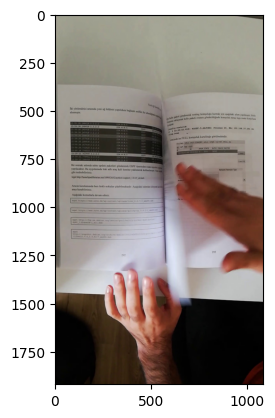

In [2]:
# Flipped Page
image_flip = cv2.imread('images/training/flip/0065_000000021.jpg')
image_flip = cv2.cvtColor(image_flip, cv2.COLOR_BGR2RGB)
plt.imshow(image_flip)

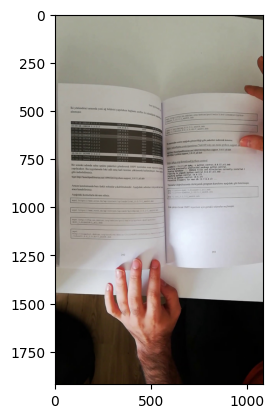

In [3]:
# Non-Flipped Page
image_nonflip = cv2.imread('images/training/notflip/0058_000000027.jpg')
image_nonflip = cv2.cvtColor(image_nonflip, cv2.COLOR_BGR2RGB)
plt.imshow(image_nonflip)

In [4]:
# Get image size and color channels
height, width, channels = image_flip.shape
print(f"Width: {width}, Height: {height}, Channels: {channels}")

Width: 1080, Height: 1920, Channels: 3


Each image in the dataset has a resolution of 1920 x 1080 pixels. For faster processing, these images have been resized to one-twentieth of their original size, maintaining the aspect ratio, resulting in a resolution of 96 x 54 pixels.

The dataset is processed using the Image Generator from the Keras library. Additionally, several data augmentation techniques have been applied to the training set, as given below.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'images/training'
test_dir = 'images/testing'

# Some data augmentation is applied
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (96, 54),
                                               batch_size = 32,
                                               class_mode = 'binary')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (96, 54),
                                             batch_size = 32,
                                             class_mode = 'binary',
                                             shuffle=False)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


### Image Classification with CNN

For classification, CNN with 2 convolutional layers is modelled and compiled with Adam optimizer.

In [6]:
model = Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (96, 54, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

In [7]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [8]:
steps_train = np.ceil(train_data.samples/train_data.batch_size)
steps_test = np.ceil(test_data.n / test_data.batch_size)

In [9]:
history = model.fit(
    train_data,
    steps_per_epoch = steps_train,
    epochs = 10,
    validation_data = test_data,
    validation_steps = steps_test) 

Epoch 1/10
75/75 [==============================] - 89s 1s/step - loss: 0.6929 - accuracy: 0.5209 - val_loss: 0.6666 - val_accuracy: 0.5997
Epoch 2/10
75/75 [==============================] - 84s 1s/step - loss: 0.6898 - accuracy: 0.5472 - val_loss: 0.6651 - val_accuracy: 0.5913
Epoch 3/10
75/75 [==============================] - 78s 1s/step - loss: 0.6658 - accuracy: 0.6108 - val_loss: 0.6184 - val_accuracy: 0.6868
Epoch 4/10
75/75 [==============================] - 83s 1s/step - loss: 0.6209 - accuracy: 0.6610 - val_loss: 0.5334 - val_accuracy: 0.7688
Epoch 5/10
75/75 [==============================] - 76s 1s/step - loss: 0.6085 - accuracy: 0.6689 - val_loss: 0.5524 - val_accuracy: 0.7069
Epoch 6/10
75/75 [==============================] - 76s 1s/step - loss: 0.5404 - accuracy: 0.7312 - val_loss: 0.4976 - val_accuracy: 0.7471
Epoch 7/10
75/75 [==============================] - 77s 1s/step - loss: 0.5718 - accuracy: 0.6957 - val_loss: 0.4883 - val_accuracy: 0.7672
Epoch 8/10
75/75 [==

### Results

In [10]:
test_data.reset()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, steps = steps_test)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(test_data, steps = steps_test)

19/19 [==============================] - 13s 664ms/step - loss: 0.3153 - accuracy: 0.8744
Test accuracy: 0.8743718862533569
19/19 [==============================] - 13s 659ms/step


In [12]:
from sklearn.metrics import classification_report

test_data.reset()

test_labels = test_data.classes
binary_predictions = (predictions > 0.5).astype(int)

# Generate the classification report
report = classification_report(test_labels, binary_predictions.flatten(), target_names=test_data.class_indices.keys())
print(report)

              precision    recall  f1-score   support

        flip       0.90      0.83      0.87       290
     notflip       0.85      0.91      0.88       307

    accuracy                           0.87       597
   macro avg       0.88      0.87      0.87       597
weighted avg       0.88      0.87      0.87       597



The CNN model gives an accuracy and f1-score of around 87%.

In [17]:
model.save('cnn_model.h5')

### Tuning

Tuning here is done with Keras Tuner using Random Search. The parameters considered here include learning and the architecture of the model itself, such as kernel size, convolution layer size, dropout rate etc.

In [13]:
def build_model(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=32),  # Tuning the number of filters 
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),  # Tuning the kernel size for the first Conv2D layer
            activation='relu',
            input_shape=(96, 54, 3)),
        MaxPooling2D(2,2),
        Conv2D(
            filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=64), 
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]), 
            activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(
            filters=hp.Int('conv_3_filter', min_value=128, max_value=256, step=128),  
            kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),  
            activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(
            units=hp.Int('dense_units', min_value=512, max_value=1024, step=512),  # Tuning number of units in the Dense layer
            activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)),  # Tuning the dropout rate
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project_dir',
    project_name='ImageClassification'
)

tuner.search(
    train_data,
    steps_per_epoch = steps_train,
    epochs=10,
    validation_data = test_data,
    validation_steps = steps_test
)

Trial 4 Complete [00h 53m 09s]
val_accuracy: 0.7107761104901632

Best val_accuracy So Far: 0.9000558455785116
Total elapsed time: 00h 53m 09s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
32                |64                |conv_1_filter
5                 |3                 |conv_1_kernel
64                |128               |conv_2_filter
3                 |3                 |conv_2_kernel
128               |128               |conv_3_filter
5                 |3                 |conv_3_kernel
1024              |1024              |dense_units
0.5               |0.5               |dropout
0.0001            |0.001             |learning_rate

Epoch 1/10
75/75 [==============================] - 99s 1s/step - loss: 0.6922 - accuracy: 0.5213 - val_loss: 0.6831 - val_accuracy: 0.5645
Epoch 2/10
75/75 [==============================] - 95s 1s/step - loss: 0.6801 - accuracy: 0.5815 - val_loss: 0.6531 - val_accuracy: 0.5930
Epoch 3/10
75/75 [===================

In [15]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 70, 64)       1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 35, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 33, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 14, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 7, 128)       0

In [16]:
from sklearn.metrics import classification_report

test_data.reset()
test_labels = test_data.classes

# Make predictions
predictions = best_model.predict(test_data, steps =steps)
binary_predictions = (predictions > 0.5).astype(int)

# Generate the classification report
report = classification_report(test_labels, binary_predictions.flatten(), target_names=test_data.class_indices.keys())
print(report)

19/19 [==============================] - 11s 577ms/step
              precision    recall  f1-score   support

        flip       0.93      0.88      0.90       290
     notflip       0.89      0.93      0.91       307

    accuracy                           0.91       597
   macro avg       0.91      0.91      0.91       597
weighted avg       0.91      0.91      0.91       597



In [17]:
# Evaluate the model
test_loss, test_acc = best_model.evaluate(test_data, steps = steps)
print('Test accuracy:', test_acc)

19/19 [==============================] - 11s 557ms/step - loss: 0.2971 - accuracy: 0.9095
Test accuracy: 0.909547746181488


The model with tuned hyperparameters give an accuracy and f1-score of approx. 91%